In [27]:
from collections import defaultdict as ddict
from copy import deepcopy as copy
import pickle
import matplotlib.pyplot as plt
import random
import os

# import tensorflow as tf

# from tensorflow import feature_column,keras
# from tensorflow.keras import layers
# from tensorflow.python.keras.layers import Input, Dense
# from tensorflow.python.keras.models import Model

import pandas as pd
import numpy as np
import seaborn as sns

from IPython.core.display import HTML
from IPython.display import Image, display

#!source activate my-rdkit-env && python 
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DSVG
from rdkit.Chem.rdmolops import SanitizeFlags
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler
from sklearn.svm import SVR
from sklearn.cluster import KMeans
import sys
#import dill
import joblib
# Set the RDKit logging level to CRITICAL, because 
# lot of RDKit errors occur during the extraction of the 
# fragments. However, the corresponding molecules are 
# corrected in the further course.
RDLogger.logger().setLevel(RDLogger.CRITICAL)

# In many cases NaN
not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])

In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8964148487714876342
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767757824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16145006256370720899
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-06-20 15:37:00.501930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:37:00.502113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:37:00.502228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:37:00.502357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:37:00.502452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [29]:
def show(df):
    return HTML(df.to_html(notebook=True))

In [30]:
#note only characters for the first 20 elements is included
#for organic molecules this should be sufficient

SMILES_CHARS = [
    ' ',
    '#', '%', '(', ')', '+', '-', '.', '/',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    '=', '@',
    'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
    'R', 'S', 'T', 'V', 'X', 'Z',
    '[', '\\', ']',
    'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
    't', 'u'
]

In [31]:
smi_enc_dict = dict( (ch, i) for i, ch in enumerate(SMILES_CHARS) )
smi_dec_dict = dict( (i, ch) for i, ch in enumerate(SMILES_CHARS)  )

In [32]:
def smiles_encoder(smiles, max_length=300):
    smi_mat = np.zeros((max_length, len(SMILES_CHARS)))
    for ID, char in enumerate(smiles):
        smi_mat[ID, smi_enc_dict[char]] = 1
    return smi_mat

def smiles_decoder(smi_mat):
    smi_str = ''
    smi_mat = smi_mat.argmax(axis=-1)
    for i in smi_mat:
        smi_str += smi_dec_dict[i]
    return smi_str


In [7]:
# Preparring datasets by matching the dataset lengths (dataX will be the SMILES strings and dataY will be individual characters in the SMILE string)
# seq_length = 137

In [33]:
sdf_path = os.path.join(os.getcwd(), 'compounds.sdf')

In [34]:
dataset = PandasTools.LoadSDF(sdf_path)

,BROAD_CPD_ID,CPD_NAME,CPD_TYPE,CPD_SMILES,ID,ROMol
0,BRD-K59962020,BRD2020,BIO,Cc1cc2nc(NCCCO)n(CC(=O)c3cc(c(O)c(c3)C(C)(C)C)...,BRD2020,
1,BRD-K15888437,BRD-K15888437,BIO,CCc1cc2c(cc1OC(C)=O)oc(C)c(-c1nc3ccccc3n1C)c2=O,BRD-K15888437,
2,BRD-K19499941,BRD-K19499941,BIO,CCCCCCCN(C(=O)CCl)c1cccc(C)c1,BRD-K19499941,
3,BRD-K03704870,BRD-K03704870,BIO,CCc1ccc(OCC(=O)Nc2nnc[nH]2)cc1,BRD-K03704870,

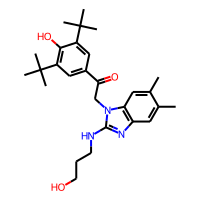
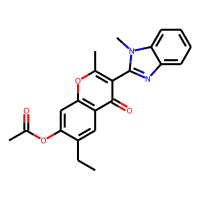
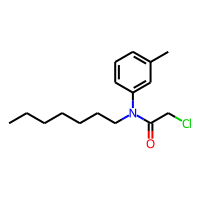
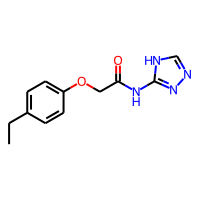

In [35]:
show(dataset.head(4))

In [36]:
smiles_train, smiles_test = train_test_split(dataset["CPD_SMILES"], random_state=20)

print(smiles_train.shape)
print(smiles_test.shape)

(24243,)
(8081,)


In [37]:
charset = set("".join(list(dataset.CPD_SMILES)) + "!E")

char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))

In [38]:
max_length = max([len(smile) for smile in dataset.CPD_SMILES]) + 5

In [39]:
print(str(charset))
print(len(charset), max_length)

{'2', '\\', 'r', 'O', 'B', '#', '7', 'H', 'I', '(', 'C', '4', '6', 'F', '!', '-', '5', 'N', 's', 'n', '.', 'P', 'e', 'S', '/', 'l', 'o', '1', ')', 'c', '[', ']', '+', '3', 'E', '=', '@'}
37 230


In [40]:
def vectorise(smiles, charset, max_length=300):
        one_hot =  np.zeros((smiles.shape[0], max_length , len(charset)))
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [41]:
X_train, Y_train = vectorise(smiles_train.values, charset, max_length=max_length)
X_test, Y_test = vectorise(smiles_train.values, charset, max_length=max_length)


In [42]:
test_smi = X_train[0]

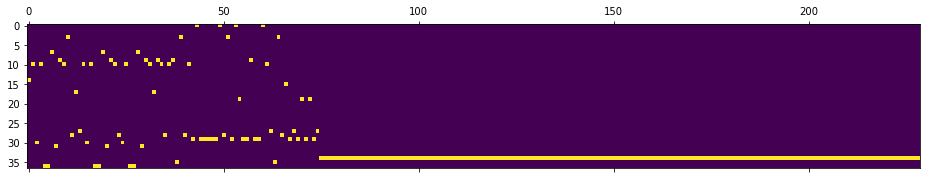

In [43]:
plt.matshow(X_train[0].T)

In [44]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
# lstm_dim = 64

ModuleNotFoundError: No module named 'tf'

In [20]:
#setup molecular encoder

inputs = Input(shape=input_shape)
mol_encoder = LSTM(64, return_state=True, unroll=False)
outputs, state_h, state_c = mol_encoder(inputs)

#concatenate states into single tensor
states = Concatenate(axis=-1)([state_h, state_c])

c_h_concat = Dense(64, activation='relu')
c_h_ouputs = c_h_concat(states)


2022-06-20 15:29:00.369169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:29:00.369345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:29:00.369438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:29:00.369642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:29:00.369737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [21]:
#now setup decoder

decode_h = Dense(64, activation='relu')
decode_c = Dense(64, activation='relu')

state_h_decoded = decode_h(c_h_ouputs)
state_c_decoded = decode_c(c_h_ouputs)

encoder_states = [state_h_decoded, state_c_decoded]

decoder_inputs = Input(shape=input_shape)
#decoder
decoder_lstm = LSTM(64,return_sequences=True, unroll=False)

decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#define the model that predicts next character
model = Model([inputs, decoder_inputs], decoder_outputs)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 37)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  26112       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        concatenate[0][0]            

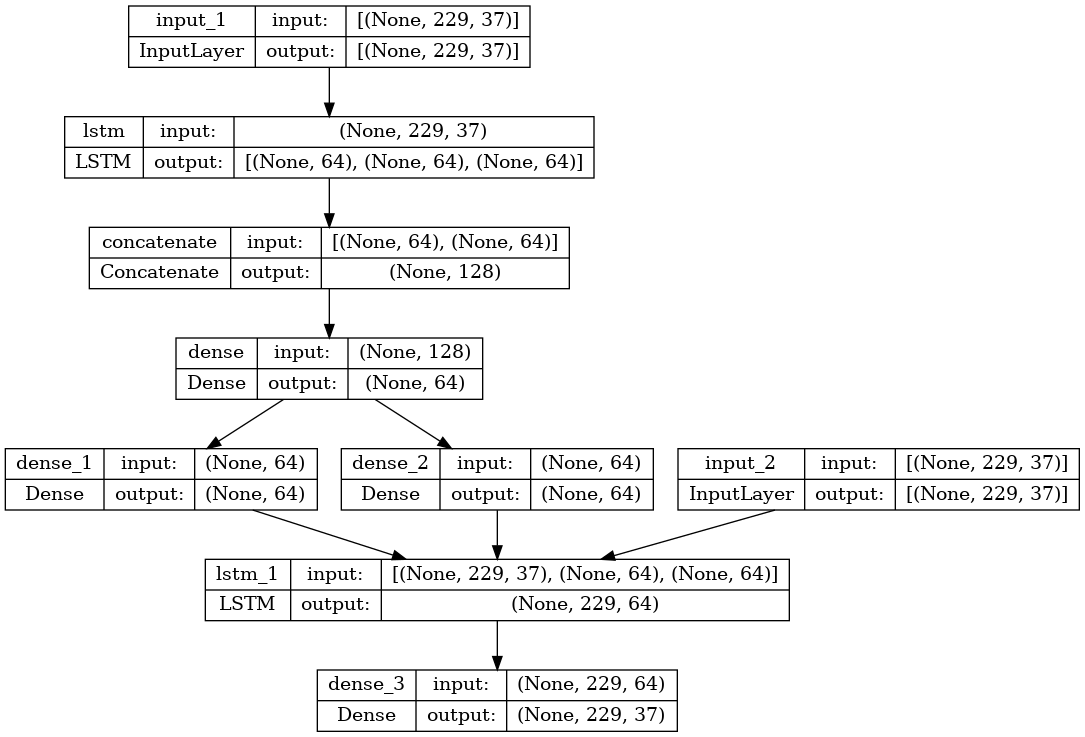

In [22]:
image_model = keras.utils.plot_model(model, "RNN_de_novo_generator.png", show_shapes=True)
display(Image(filename="RNN_de_novo_generator.png"))

In [23]:
from tensorflow.keras.callbacks import History, ReduceLROnPlateau
h = History()
red_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)

In [26]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')

ValueError: Could not interpret optimizer identifier: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7f6eac440910>

In [ ]:
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, red_LR],
                    validation_data=[[X_test,X_test],Y_test ])

In [ ]:
#decoder model
